## Test the dataset module

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("../../datasets/results.csv", delimiter="|")
train_df, test_df = train_test_split(df, test_size=0.02, random_state=42)

image_dir = "../../datasets/flickr30k_images"

In [2]:
from datasets import get_train_test_dataloader

train_loader, test_loader = get_train_test_dataloader(train_df, test_df, image_dir, batch_size=4)

In [3]:
train_loader.batch_size, len(list(train_loader))

(4, 1)

In [5]:
train_first_data = next(iter(train_loader))

train_first_data[0].shape, train_first_data[1]

(torch.Size([4, 3, 224, 224]),
 (' Four men on top of a tall structure .',
  ' Two men working on a machine wearing hard hats .',
  ' Three men on a large rig .',
  ' Several men in hard hats are operating a giant pulley system .'))

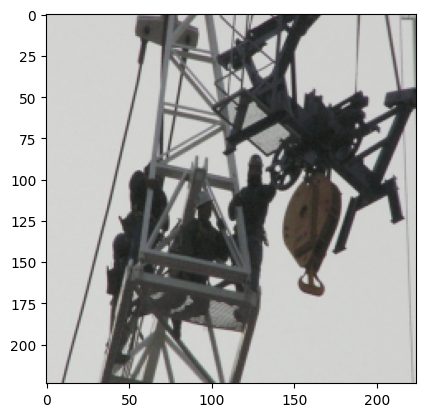

In [6]:
import matplotlib.pyplot as plt

plt.imshow(train_first_data[0][0].permute(1, 2, 0))

---

## Test the vision-transformer module

In [7]:
import torch
from vision_transformer_encoder import ViTEncoder

# RANDOM_SEED = 42
BATCH_SIZE = 10
EPOCHS = 20

LEARNING_RATE = 1e-3
PATCH_SIZE = 16
IMG_SIZE = 224
IN_CHANNELS = 3
NUM_HEADS = 8
DROPOUT = 0.001
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)
ACTIVATION = "gelu"
NUM_ENCODERS = 4
EMBED_DIM = (PATCH_SIZE**2) * IN_CHANNELS  # 768
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2  # 196


device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
model = ViTEncoder(
    NUM_PATCHES,
    IMG_SIZE,
    PATCH_SIZE,
    EMBED_DIM,
    NUM_ENCODERS,
    NUM_HEADS,
    DROPOUT,
    ACTIVATION,
    IN_CHANNELS,
).to(device)

TypeError: not all arguments converted during string formatting

In [ ]:
random_image = torch.randn(BATCH_SIZE, 3, 224, 224).clip(0,1).to(device)
print(f"{BATCH_SIZE=}")
print(f"{random_image.shape=}")

print(model(random_image).shape)  # BATCH_SIZE X (NUM_PATCHES+1) X EMBED_DIM

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(random_image[0].permute(1, 2, 0).cpu().detach())

----

## Test the vocabulary module

In [9]:
import pandas as pd
from caption_vocab import MyVocab

df = pd.read_csv("../../datasets/results.csv", delimiter="|")
my_vocab = MyVocab(df=df, column_name=" comment")

In [10]:
import numpy as np

token_arr = my_vocab.get_token_index_from_sentence(
    "Several men in hard hats are operating a giant pulley system .",max_len=20
)

np.shape(token_arr), token_arr[0][10:]  # after 10th token

(torch.Size([1, 20]), tensor([24, 28,  4,  3,  1,  1,  1,  1,  1,  1]))

In [11]:
token_arr = my_vocab.get_token_index_from_sentence(
    ["Several men in hard hats are operating a giant pulley system ."], max_len=20
)

np.shape(token_arr), token_arr[0][10:]  # after 10th token

(torch.Size([1, 20]), tensor([24, 28,  4,  3,  1,  1,  1,  1,  1,  1]))

In [12]:
my_vocab.PAD_IDX, my_vocab.BOS_IDX, my_vocab.EOS_IDX, my_vocab.UNK_IDX

(1, 2, 3, 0)

In [13]:
len(my_vocab)

37

In [14]:
my_vocab.get_sentence_from_indices(token_arr[0].tolist())

['several men in hard hats are operating a giant pulley system .']

In [15]:
my_vocab.get_sentence_from_indices(token_arr.tolist())

['several men in hard hats are operating a giant pulley system .']

---

## Test the `Caption Generator Decoder` module

In [ ]:
import torch

dummy_encoder_output = torch.randn(4, 197, 256) # BATCH_SIZE X (NUM_PATCHES+1) X EMBED_DIM

In [ ]:
my_dummy_captions = [
    "Several men in hard hats are operating a giant pulley system .",
    "operating a giant pulley system .",
    "in hard hats are operating .",
    "Several men in ",
]
meow_meow = my_vocab.get_token_index_from_sentence(
        my_dummy_captions, max_len=20
    )
meow_meow

In [ ]:
my_padding_mask = my_vocab.create_padding_mask(meow_meow)
my_subsequent_mask = my_vocab.create_square_subsequent_mask(20) # max_len

In [ ]:
my_padding_mask

In [ ]:
my_subsequent_mask

In [ ]:
from caption_generator_decoder import ImageCaptionDecoder

TGT_VOCAB_SIZE = len(my_vocab)
EMBED_DIM = 256
NUM_HEADS = 8
NUM_ENCODERS = 6
DROPOUT = 0.1
ACTIVATION = "gelu"
TGT_MAX_LEN = 20

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
my_img_caption_decoder = ImageCaptionDecoder(
    tgt_vocab_size=TGT_VOCAB_SIZE,
    emb_size=EMBED_DIM,
    nhead=NUM_HEADS,
    num_decoder_layers=NUM_ENCODERS,
    dropout=DROPOUT,
    activation=ACTIVATION,
    tgt_max_len=TGT_MAX_LEN,
).to(device)

In [ ]:
final_output = my_img_caption_decoder(
    trg=meow_meow,
    memory=dummy_encoder_output,
    tgt_mask=my_subsequent_mask,
    tgt_key_padding_mask=my_padding_mask,
)

In [ ]:
final_output.shape  # BATCH_SIZE X TGT_MAX_LEN X TGT_VOCAB_SIZE (4, 20, 37)

In [ ]:
meow_meow.shape, dummy_encoder_output.shape

---

## loss function

In [ ]:
import torch.nn as nn

loss_fn = torch.nn.NLLLoss(ignore_index=my_vocab.PAD_IDX)

In [ ]:
dummy_real_output = torch.randint(0, TGT_VOCAB_SIZE, (4, 20)).to(device)
dummy_real_output.shape, final_output.shape, dummy_real_output

In [ ]:
loss = loss_fn(final_output.permute(0, 2, 1), dummy_real_output)

In [ ]:
loss